<a href="https://colab.research.google.com/github/qazalmehrban/Medical-Segmentation/blob/ghazal/Unet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from skimage.transform import resize
import numpy as np
import nibabel as nib
import os 

import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
samples = '/content/drive/MyDrive/samples/'
patients = next(os.walk(samples))[2]
labels = '/content/drive/MyDrive/segmentation/'
segmentations =next(os.walk(labels))[2]


In [4]:
patients.sort()
segmentations.sort()

In [5]:
def description(samples):
  unique_spational = set()
  all_spational_slice = []
  patients = os.listdir(samples)
  patients.sort()
  for number_file, image_id  in enumerate(patients):
    im = nib.load(os.path.join(samples, image_id))    
    im = np.array(im.dataobj)
    unique_spational.add(im.shape[:2])
    for slices in range(im.shape[2]):

      all_spational_slice.append(im.shape[:2])
  print(f"there are {len(unique_spational)} unique spational dimension")
  print(f"there are {number_file} patient image")
  for i in unique_spational:
   print(f'there are {all_spational_slice.count(i)} slice with shape {i}')


In [ ]:
description(samples)

In [6]:
def description_mask(labels):
  segmentations = os.listdir(labels)
  segmentations.sort()

  k = set()
  num = []
  for i1 in segmentations:
    
    Masks = nib.load(os.path.join(labels, i1))    
    Masks = np.array(Masks.dataobj)
    for  j in range(Masks.shape[2]):
      u = np.unique(Masks[:,:,j])
      u = tuple(u.astype(np.int))
      k.add(u)
      num.append(u)
  for i in k :
    print(f'there are {num.count(i)} slice with label {i}')



In [ ]:
description_mask(labels)

In [7]:
def make_box(mask):
    box = []
    box_bool=[]
    obj_ids = np.unique(mask)
    if mask.dtype == bool:
        if len(np.unique(mask))==2:
            
            y_min = np.nonzero(mask)[0].min()
            y_max = np.nonzero(mask)[0].max()
            x_min = np.nonzero(mask)[1].min()
            x_max = np.nonzero(mask)[1].max()
            box=[x_min, y_min, x_max, y_max]
    else :
        mask_bool = mask.astype(np.bool)
        if len(np.unique(mask_bool))==2:
            
            y_min = np.nonzero(mask_bool)[0].min()
            y_max = np.nonzero(mask_bool)[0].max()
            x_min = np.nonzero(mask_bool)[1].min()
            x_max = np.nonzero(mask_bool)[1].max()
            box_bool=[x_min, y_min, x_max, y_max]
        
        for i in  obj_ids[1:]:
            y_min = np.nonzero(mask==i)[0].min()
            y_max = np.nonzero(mask==i)[0].max()
            x_min = np.nonzero(mask==i)[1].min()
            x_max = np.nonzero(mask==i)[1].max()
            box.append([x_min, y_min, x_max, y_max])
    return_object = box if mask.dtype ==bool else (dict(zip([f"label{int(i)}" for i in obj_ids[1:]],box)), box_bool)
    return return_object

In [ ]:
Masks = nib.load((labels + segmentations[0]))    
Masks = np.array(Masks.dataobj)
print('shape', Masks.shape)
slices =7
Masks_2d = Masks[:,:,slices]
print(f'labels_slice_{slices}', np.unique(Masks_2d))
print('bounding_box', make_box(Masks_2d.astype(bool)))
plt.imshow(Masks_2d)

In [ ]:
Masks = nib.load((labels + segmentations[0]))    
Masks = np.array(Masks.dataobj)
print('shape', Masks.shape)
slices =1
Masks_2d = Masks[:,:,slices]
print(f'labels_slice_{slices}', np.unique(Masks_2d))
print('bounding_box', make_box(Masks_2d))
plt.imshow(Masks_2d)

In [8]:
def crop_specific(im, mask, crop_size):
        
        k=make_box(mask.astype(np.bool))
        if len(k)!=0:
            b_list = k
            x_min, y_min, x_max, y_max = b_list
            
            length_x = x_max -x_min + 1
            length_y = y_max - y_min + 1
            del_x = crop_size - length_x 
            del_y = crop_size - length_y 

            if del_x%2==0:
                kx = del_x//2
                sx=0
            else:
                kx = del_x//2

                sx = 1
            if del_y%2==0:
                ky = del_y//2
                sy=0
            else:
                ky = del_y//2
                sy = 1
            
            crop = mask[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            crop_im = im[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            return crop_im, crop, 


In [ ]:
len(segmentations)

53

In [9]:
crop_size = 192
p_seg = []
p_im = []
for i, i1 in zip(segmentations[:45], patients[:45]):
    im = nib.load(os.path.join(samples, i1))    
    im = np.array(im.dataobj)

    Masks = nib.load(os.path.join(labels, i))    
    Masks = np.array(Masks.dataobj)
    Masks.shape
    for  j in range(Masks.shape[2]):
      k=make_box(Masks[:,:,j].astype(np.bool))
      if len(k)!=0:
        crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
        p_seg.append(crop)
        p_im.append(crop_im)


    
   

In [10]:
crop_size = 192
p_seg_t = []
p_im_t = []
for i, i1 in zip(segmentations[45:], patients[45:]):
    im = nib.load(os.path.join(samples, i1))    
    im = np.array(im.dataobj)

    Masks = nib.load(os.path.join(labels, i))    
    Masks = np.array(Masks.dataobj)
    Masks.shape
    for  j in range(Masks.shape[2]):
      k=make_box(Masks[:,:,j].astype(np.bool))
      if len(k)!=0:
        crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
        p_seg_t.append(crop)
        p_im_t.append(crop_im)



In [11]:
segment_numpy = np.stack(p_seg,2)
image_numpy = np.stack(p_im, 2)

segment_numpy_t = np.stack(p_seg_t,2)
image_numpy_t = np.stack(p_im_t, 2)

In [12]:
train = image_numpy/image_numpy.max()
test = image_numpy_t/image_numpy.max()

In [13]:
train_image  = np.transpose(train,(2,0,1))
test_image  = np.transpose(test,(2,0,1))

In [14]:
train_seg = np.transpose(segment_numpy,(2,0,1))
test_seg = np.transpose(segment_numpy_t,(2,0,1))

In [15]:
train_seg_bolean = train_seg.astype(bool)
test_seg_bolean = test_seg.astype(bool)

In [16]:
train_seg_f = train_seg_bolean.astype(float)
test_seg_f = test_seg_bolean.astype(float)

In [17]:
test_seg_f.shape

(122, 192, 192)

# Model

In [ ]:
img_size = (crop_size, crop_size)

In [ ]:


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, 3)
model.summary()

# train

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("unet_seg.h5", save_best_only=True)
]

epochs = 50
model.fit(tra, seg, epochs=epochs, batch_size=32)

In [ ]:

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


In [ ]:

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

pr = model.predict(tra[:670])

In [ ]:
pr.shape

In [ ]:
mask1 = np.argmax(pr[46], axis=-1)
plt.imshow(mask1)


In [ ]:
plt.imshow(seg_f[46])

In [ ]:
np.unique(seg_f[46])

In [ ]:
plt.imshow(seg[46])

In [ ]:
pr[2]

# Traditional Unet

In [18]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 192, 192, 1


In [19]:
from tensorflow.keras import layers

# Croos entropy loss

In [20]:
def U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    
    inputs = tf.keras.Input(input_size)
    
    
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)


    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)


    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)


    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)


    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c5)



    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)   


    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7) 

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c8) 
    
    
    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis = 3)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9) 
    
    outputs = layers.Conv2D(2,(1,1), activation="softmax",)(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    return model

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

In [54]:
def Mean_IOU_Evaluator(y_true, y_pred):

    
    
  mask1 = tf.math.argmax(y_pred, axis=-1)

  y_pred= tf.cast(mask1, tf.int32)
  l = []
  for  i,j in zip(y_pred, y_true):
    inter = tf.reduce_sum(i, j)
    union = tf.reduce_sum(j) + tf.reduce_sum(j)
    l.append(inter/union)
  des = sum(l)/len(y_pred)
       
  return des

model = U_Net_Segmentation()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 192, 192, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 192, 192, 16) 0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 192, 192, 16) 2320        dropout_27[0][0]                 
____________________________________________________________________________________________

In [59]:
for i, j in zip(y_pred, y_pred):
  print(i)

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(192, 192), dtype=int32)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(192, 192), dtype=int32)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(192, 192), dtype=int32)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(192, 192), dtype=int32)


In [55]:
optimizer = tf.keras.optimizers.Adam()


In [56]:
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[Mean_IOU_Evaluator])
                 

In [57]:
results = model.fit(train_image, train_seg_f,
                    shuffle = False,
              validation_split = 0.1,
                    batch_size=32,
                    epochs=50)

Epoch 1/50


TypeError: ignored

In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

pr = model.predict(test_image[:7])

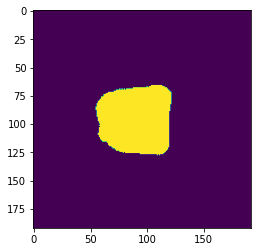

In [ ]:
mask1 = np.argmax(pr[2], axis=-1)
plt.imshow(mask1)


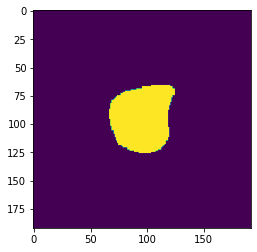

In [ ]:
plt.imshow(test_seg_f[2])


# Dice loss

In [ ]:
def U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    
    inputs = tf.keras.Input(input_size)
    
    
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)


    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)


    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)


    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)


    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c5)



    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)   


    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7) 

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c8) 
    
    
    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis = 3)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9) 
    
    outputs = layers.Conv2D(1,(1,1), activation="softmax",)(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    return model

In [ ]:
model = U_Net_Segmentation()

In [ ]:
def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator/ denominator

In [ ]:
optimizer = tf.keras.optimizers.Adam()


In [ ]:
model.compile(optimizer=optimizer, loss=dice_loss
                 )

In [ ]:
results = model.fit(tra, seg,
                    shuffle = False, 
                    validation_split=0.1, 
                    batch_size=32,
                    epochs=50)